In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
tr_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv"
ts_path = "https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv"

In [3]:
train_df = pd.read_csv(tr_path)
train_df = train_df.reindex(np.random.permutation(train_df.index))
test_df = pd.read_csv(ts_path)

In [4]:
class Normalization(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(1, 1)
        self.mean = 0
        self.std = 0

    def forward(self, x):
        feature_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(dim=1)
        self.mean = torch.mean(feature_tensor)
        self.std = torch.std(feature_tensor)
        return (feature_tensor - self.mean) / self.std

In [5]:
class DiscretizationLayer(nn.Module):
    def __init__(self, bin_boundaries):
        super().__init__()
        self.bin_boundaries = torch.tensor(bin_boundaries, dtype=torch.float32)

    def forward(self, x):
        return torch.bucketize(x, self.bin_boundaries)

In [8]:
import tensorflow as tf

latitude_norm = Normalization()
latitude_norm = latitude_norm(train_df['latitude'])
latitude_boundaries = np.linspace(-3, 3, 20+1)
latitude_discretized = DiscretizationLayer(latitude_boundaries)
latitude_discretized = latitude_discretized(latitude_norm)

longitude_norm = Normalization()
longitude_norm = longitude_norm(train_df['longitude'])
longitude_boundaries = np.linspace(-3, 3, 20+1)
longitude_discretized = DiscretizationLayer(longitude_boundaries)
longitude_discretized = longitude_discretized(longitude_norm)

longitude_tf_tensors = tf.convert_to_tensor(longitude_discretized.detach().numpy())
latitude_tf_tnesors = tf.convert_to_tensor(latitude_discretized.detach().numpy())

feature_cross_output = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude_tf_tnesors, longitude_tf_tensors])

In [21]:
median_income_norm = Normalization()
median_income_norm = median_income_norm(train_df['median_income'])

population_norm = Normalization()
population_norm = population_norm(train_df['population'])

feature_cross = torch.tensor(feature_cross_output.numpy(), dtype = torch.float32)

In [31]:
preprocessed_input = torch.cat([feature_cross, median_income_norm, population_norm],
                               dim=1)

In [34]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()                
        self.linear = nn.Linear(in_features=443, out_features=1)

    def forward(self, x):
        return self.linear(x)

In [92]:
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"
validation_split = 0.2

model = LinearRegression()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [86]:
label_tensor = Normalization()
label_tensor = label_tensor(train_df[label_name])

In [87]:
total_samples = len(train_df)
train_size = int((1 - validation_split) * total_samples)
val_size = total_samples - train_size

In [88]:
dataset = torch.utils.data.TensorDataset(preprocessed_input, median_house_norm)

train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                           [train_size, val_size])
    
    
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True)
    
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size, shuffle=True)

In [94]:
tr_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    model.train()
    tr_epoch_loss = 0.0
    for batch_feature, batch_label in train_dataloader:
        train_preds = model(batch_feature)
        train_loss = criterion(train_preds, batch_label)
        
        optimizer.zero_grad()   
        train_loss.backward()   
        optimizer.step()
        tr_epoch_loss += train_loss.item()
    
    tr_loss_list.append(tr_epoch_loss / len(train_dataloader))
    
    model.eval()    
    with torch.no_grad():
        val_epoch_loss = 0.0
        for batch_feature, batch_label in val_dataloader:
            val_preds = model(batch_feature)
            val_loss  = criterion(val_preds, batch_label).item()
            val_epoch_loss += val_loss
        val_loss_list.append(val_epoch_loss / len(val_dataloader))
        
    print(f"Epoch: {epoch} | Train Loss: {tr_epoch_loss / len(train_dataloader)} | Validation Loss: {tr_val_loss / len(val_dataloader)}")

Epoch: 0 | Train Loss: 0.8906987862927573 | Validation Loss: 0.1469443440437317
Epoch: 1 | Train Loss: 0.6414895866598401 | Validation Loss: 0.1469443440437317
Epoch: 2 | Train Loss: 0.4885131482567106 | Validation Loss: 0.1469443440437317
Epoch: 3 | Train Loss: 0.40521910573754993 | Validation Loss: 0.1469443440437317
Epoch: 4 | Train Loss: 0.365046745964459 | Validation Loss: 0.1469443440437317
Epoch: 5 | Train Loss: 0.3483814724854061 | Validation Loss: 0.1469443440437317
Epoch: 6 | Train Loss: 0.34048678832394735 | Validation Loss: 0.1469443440437317
Epoch: 7 | Train Loss: 0.3383647011859076 | Validation Loss: 0.1469443440437317
Epoch: 8 | Train Loss: 0.3359633535146713 | Validation Loss: 0.1469443440437317
Epoch: 9 | Train Loss: 0.3367744897093092 | Validation Loss: 0.1469443440437317
Epoch: 10 | Train Loss: 0.3362488512481962 | Validation Loss: 0.1469443440437317
Epoch: 11 | Train Loss: 0.33800309896469116 | Validation Loss: 0.1469443440437317
Epoch: 12 | Train Loss: 0.3349352117

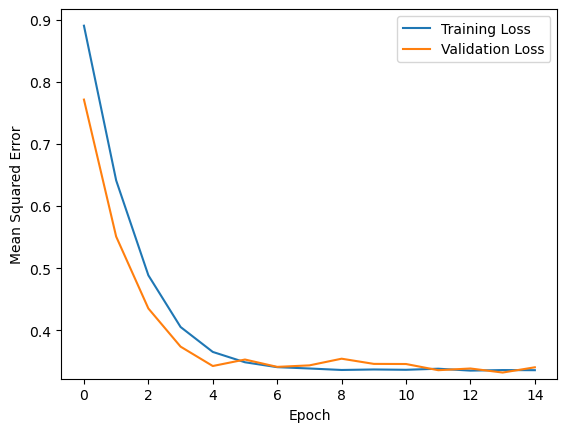

In [106]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(range(epochs), tr_loss_list, label="Training Loss")
plt.plot(range(epochs), val_loss_list, label="Validation Loss")

merged_mse_lists = tr_loss_list + val_loss_list
highest_loss = max(merged_mse_lists)
lowest_loss = min(merged_mse_lists)
top_of_y_axis = highest_loss * 1.03
bottom_of_y_axis = lowest_loss * 0.97

plt.ylim([bottom_of_y_axis, top_of_y_axis])
plt.legend()
plt.show()

In [108]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=443, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=12)
        self.layer_3 = nn.Linear(in_features=12, out_features=1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

In [110]:
learning_rate = 0.01
epochs = 20
batch_size = 1000
label_name = "median_house_value"
validation_split = 0.2

model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [111]:
tr_loss_list = []
val_loss_list = []

for epoch in range(epochs):
    model.train()
    tr_epoch_loss = 0.0
    for batch_feature, batch_label in train_dataloader:
        train_preds = model(batch_feature)
        train_loss = criterion(train_preds, batch_label)
        
        optimizer.zero_grad()   
        train_loss.backward()   
        optimizer.step()
        tr_epoch_loss += train_loss.item()
    
    tr_loss_list.append(tr_epoch_loss / len(train_dataloader))
    
    model.eval()    
    with torch.no_grad():
        val_epoch_loss = 0.0
        for batch_feature, batch_label in val_dataloader:
            val_preds = model(batch_feature)
            val_loss  = criterion(val_preds, batch_label).item()
            val_epoch_loss += val_loss
        val_loss_list.append(val_epoch_loss / len(val_dataloader))
        
    print(f"Epoch: {epoch} | Train Loss: {tr_epoch_loss / len(train_dataloader)} | Validation Loss: {tr_val_loss / len(val_dataloader)}")

Epoch: 0 | Train Loss: 0.8272476324013301 | Validation Loss: 0.1469443440437317
Epoch: 1 | Train Loss: 0.4017315421785627 | Validation Loss: 0.1469443440437317
Epoch: 2 | Train Loss: 0.3459459160055433 | Validation Loss: 0.1469443440437317
Epoch: 3 | Train Loss: 0.3315136453935078 | Validation Loss: 0.1469443440437317
Epoch: 4 | Train Loss: 0.32611148272241863 | Validation Loss: 0.1469443440437317
Epoch: 5 | Train Loss: 0.32224901020526886 | Validation Loss: 0.1469443440437317
Epoch: 6 | Train Loss: 0.3229743391275406 | Validation Loss: 0.1469443440437317
Epoch: 7 | Train Loss: 0.32078916473048075 | Validation Loss: 0.1469443440437317
Epoch: 8 | Train Loss: 0.31787817605904173 | Validation Loss: 0.1469443440437317
Epoch: 9 | Train Loss: 0.3205310276576451 | Validation Loss: 0.1469443440437317
Epoch: 10 | Train Loss: 0.31850503172193256 | Validation Loss: 0.1469443440437317
Epoch: 11 | Train Loss: 0.31748978793621063 | Validation Loss: 0.1469443440437317
Epoch: 12 | Train Loss: 0.315304

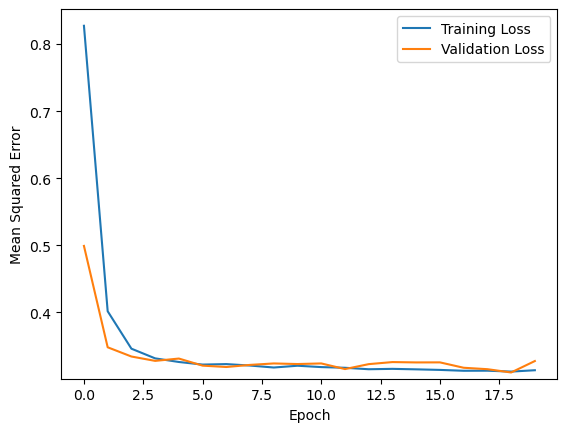

In [112]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")

plt.plot(range(epochs), tr_loss_list, label="Training Loss")
plt.plot(range(epochs), val_loss_list, label="Validation Loss")

merged_mse_lists = tr_loss_list + val_loss_list
highest_loss = max(merged_mse_lists)
lowest_loss = min(merged_mse_lists)
top_of_y_axis = highest_loss * 1.03
bottom_of_y_axis = lowest_loss * 0.97

plt.ylim([bottom_of_y_axis, top_of_y_axis])
plt.legend()
plt.show()